# ML Interview Test

## Objective

Predict whether a customer will purchase a product based on their demographic information.

## Dataset

A small dataset with the following columns:
- `Age`: Age of the customer
- `Income`: Annual income of the customer (in thousands of dollars)
- `Gender`: Gender of the customer (`Male` or `Female`)
- `Purchased`: Whether the customer purchased the product (`0` for No, `1` for Yes)

## Task

Create a simple machine learning model to predict the `Purchased` column based on the other features.

## Binder link

https://mybinder.org/v2/gh/VassilisSaplamidis/interview_tasks_quant/main

## Step 1: Data Preparation

1. Load the dataset.
2. Encode the `Gender` column.
3. Split the data into features (`X`) and target (`y`).
4. Split the data into training and test sets.

In [121]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Load the dataset
data = pd.read_csv('raw_data.csv',delimiter=';')
data.set_index('datetime_utc_from', inplace=True)
data.index = pd.to_datetime(data.index)


## Step 2: Model Building

Preproccess and build features

In [118]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor

# Encode the day-of-week, month columns
data['day_of_week'] = data.index.dayofweek
data['hour'] = data.index.hour
data['month'] = data.index.month

# Split the data into features (X) and target (y)
feature_cols = ['spot_ch_eurpmwh', 'temperature_celsius', 'global_radiation_J', 'day_of_week', 'hour', 'month']
X = data[feature_cols]
y = data['consumption_MWh']

# One-hot encode categorical features
categorical_features = ['day_of_week', 'hour', 'month']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_cats = encoder.fit_transform(X[categorical_features])

# Create a dataframe for the encoded features
encoded_df = pd.DataFrame(encoded_cats, index=X.index, columns=encoder.get_feature_names_out(categorical_features))
X_encoded = pd.concat([X.drop(columns=categorical_features), encoded_df], axis=1)

# Define the date range for the test set
test_start_date = '2023-11-15'
test_end_date = '2023-11-25'

test_indices = (data.index >= test_start_date) & (data.index <= test_end_date)
train_indices = ~test_indices

X_train = X_encoded[train_indices]
X_test = X_encoded[test_indices]
y_train = y[train_indices]
y_test = y[test_indices]

if (X_train.isnull().sum().sum() > 0) or (y_train.isnull().sum() > 0):
    raise ValueError("Training data contains NaN values. Please clean the data before proceeding.")


Train the model and tune the hyperparameters

In [119]:
# Define the column transformer with scaling and one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['spot_ch_eurpmwh','temperature_celsius', 'global_radiation_J']),
    ])

# Define the Ridge regression pipeline
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ridge', Ridge())
])

# Define the Gradient Boosting Regressor pipeline
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('gb', GradientBoostingRegressor())
])

# Define the parameter grid for GridSearchCV
param_grid = [
    {
        'ridge__alpha': np.logspace(-3, 3, 7),
        'preprocessor__num__with_mean': [True, False],  # Add any preprocessing hyperparameters here
        'preprocessor__num__with_std': [True, False]
    },
    {
        'gb': [GradientBoostingRegressor()]  # No hyperparameters for GradientBoostingRegressor
    }
]

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(
    estimator=Pipeline(steps=[('preprocessor', preprocessor), ('model', Ridge())]),
    param_grid=[
        {
            'model': [Ridge()],
            'model__alpha': np.logspace(-3, 3, 7)
        },
        {
            'model': [GradientBoostingRegressor()]
        }
    ],
    cv=5,
    scoring='neg_mean_squared_error'
)

try:
    grid_search.fit(X_train, y_train)
except Exception as e:
    print(f"Grid search failed: {e}")
    raise

## Step 3: Evaluation

Evaluate the model's accuracy on the test data.

Best parameters: {'model': GradientBoostingRegressor()}
Best cross-validation score: 101.33499439942376
Test set score: 110.91494450862986


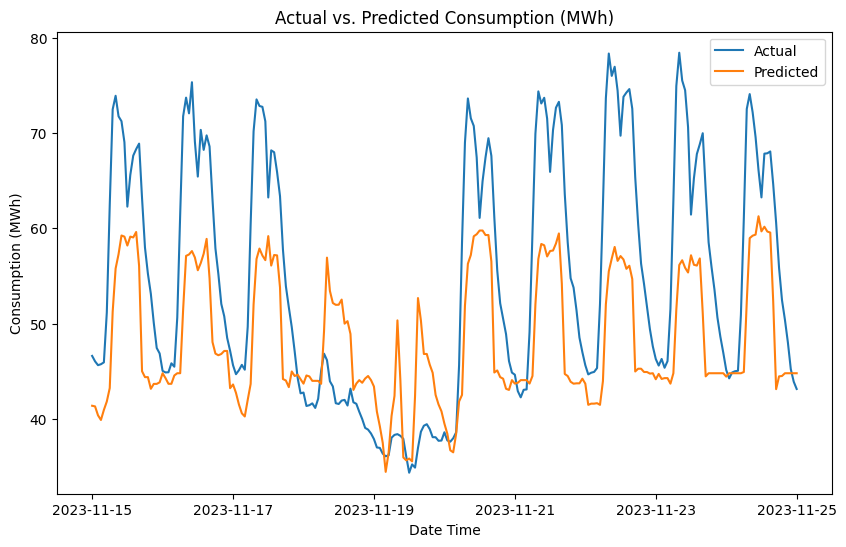

In [120]:
import matplotlib.pyplot as plt

# Print the best parameters and the corresponding score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {-grid_search.best_score_}")

# Evaluate the model on the test set
test_score = grid_search.score(X_test, y_test)
print(f"Test set score: {-test_score}")

# Get the predictions for the test set
y_pred = grid_search.predict(X_test)

# Plot the actual values vs. the predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')

plt.xlabel('Date Time')
plt.ylabel('Consumption (MWh)')
plt.title('Actual vs. Predicted Consumption (MWh)')
plt.legend()
plt.show()
